In [1]:
import numpy as np
import pandas as pd
import itertools as it

import matplotlib.pyplot as plt

from scipy import stats

from PIL import Image
import imageio
import scipy.ndimage as spimg
from skimage.segmentation import slic

In [2]:
%config Completer.use_jedi = False

## HexArray

In [3]:
myhex = np.zeros((12,12)) 

In [4]:
myhex[0:1,3:9] = 1
myhex[1:3,2:10] = 1
myhex[3:5,1:11] = 1
myhex[5:7,:12] = 1
myhex[7:9,1:11] = 1
myhex[9:11,2:10] = 1
myhex[11:12,3:9] = 1

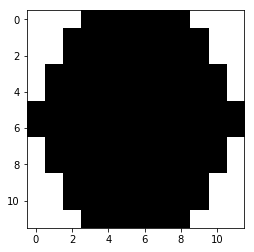

In [5]:
plt.imshow(myhex, cmap='binary');

In [6]:
hex_array = np.ones((222,399), dtype=int)*255
hex_coords = pd.DataFrame(0,index=pd.MultiIndex.from_product([range(1,45), range(1,19)], names=['X','Y']),columns=['hex_xstart','hex_ystart','center_start'])

In [7]:
def make_low_res(arr, background=255):
    def run_through_2d(channel):
        hex_array = np.ones((222,399), dtype=int)*background
        for y, x in it.product(range(1,19),range(1,45)):
            xstart = int(6*(x-1)*1.5) # please don't ask me how I figured this equation out, it works
            ystart = (y-1)*12
            if x % 2 == 0:  
                ystart = ystart + 6

            hex_coords.loc[(x,y),'hex_xstart'] = xstart
            hex_coords.loc[(x,y),'hex_ystart'] = ystart
            hex_coords.loc[(x,y),'center_xstart'] = xstart + 5
            hex_coords.loc[(x,y),'center_ystart'] = ystart + 5

            yend = ystart + 12
            xend = xstart + 12

            # val should be adjusted depending on what is to be plotted
            val = int(channel[ystart:yend,xstart:xend].mean())
            
            current_hex = hex_array[ystart:yend,xstart:xend]
            hex_array[ystart:yend,xstart:xend] = np.where(myhex, val, current_hex)
        return hex_array

    shape = arr.shape
    
    if len(shape) == 2:
        new_arr = run_through_2d(arr)
        return new_arr
    elif len(shape) == 3:
        numchan = arr.shape[-1]
        lowres_list = list()
        for channel_num in range(numchan):
            channel = arr[:,:,channel_num]
            new_channel = run_through_2d(channel)
            lowres_list.append(new_channel)
        new_arr = np.stack(lowres_list,axis=2)
        return new_arr
    else:
        print('Only arrays of 2 or 3 dimensions supported.')
        return

## Importing and Fixing up Liver Image

In [10]:
liver_origI = Image.open('/myvol/data2/pics/liver.pic.png').convert('RGB')
liver_origA = np.array(liver_origI)

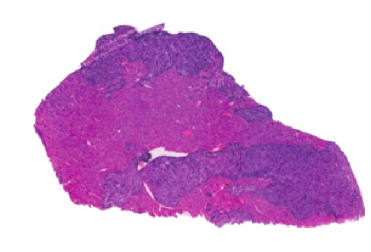

In [11]:
plt.imshow(liver_origA);
plt.axis('off');

In [12]:
hex_shape = hex_array.shape
hex_shape

(222, 399)

In [13]:
liver_shape = liver_origA.shape
liver_shape

(581, 885, 3)

Liver needs to be resized (with the same aspect ratio). First, confirm which dimension to shrink by and then use the `thumbnail()` function to shrink.

In [14]:
print(int((hex_shape[0]/liver_shape[0])*liver_shape[1]) < liver_shape[1])

True


Shrink using second axis.

In [15]:
liver_origI.thumbnail((1e6, hex_shape[0]))

In [16]:
liver_origA = np.array(liver_origI)

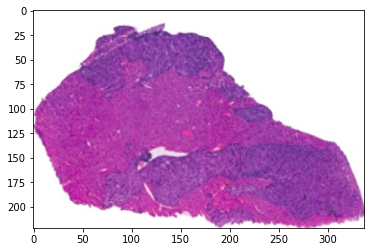

In [17]:
plt.imshow(liver_origA);
# plt.axis('off');

And now pad to get to actual size of the array and then center:

In [18]:
pad_length = int((hex_array.shape[1] - liver_origA.shape[1])/2)
liver_origA = np.pad(liver_origA, ((0,0), (pad_length, pad_length), (0,0)), mode='constant', constant_values=255)
liver_origA = spimg.shift(liver_origA,(-6,0,0), cval=255)

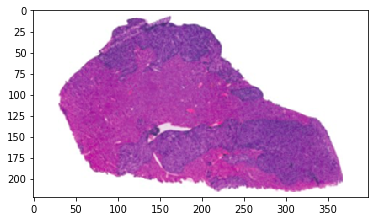

In [19]:
plt.imshow(liver_origA);

## Segmentation

First just explore the three color channels:

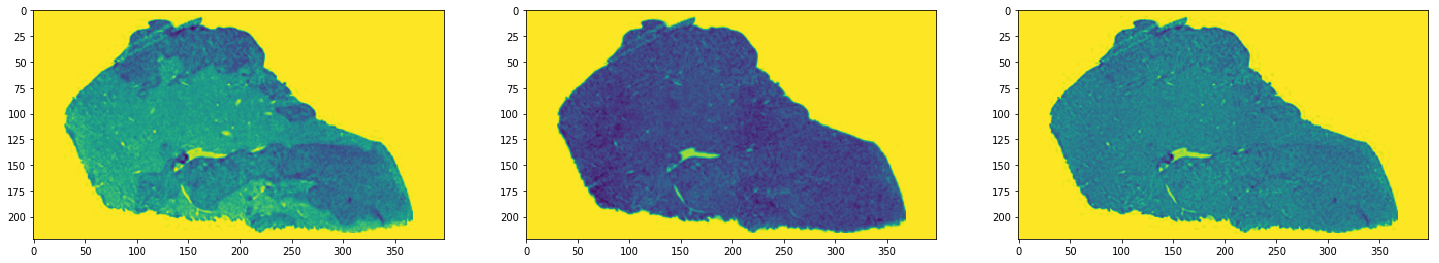

In [20]:
fig, ax = plt.subplots(1,3,figsize=(25,5))
for channel, ax in zip(range(3), ax):
    ax.imshow(liver_origA[:,:,channel]);

Looks like most of the variation is in channel 0 (Red). I'll keep all three though, just because there's still a little information in the other channels.

After playing around a bunch with different filters, I've just decided to use the `slic()` segmentation algorithm and manually annotate what's MC38 and what's liver using ImageJ's flood fill tool. It's not automated, but it was the fastest path to what I needed to do. `slic()` assigns an arbitrary value to the pixels in the same segment, so for better visualization of the segments, I map the old color values to a random color value, and then also map it to the **median** value of the pixels on the actual pixel (or any other measure of the pixels, as can be seen I tried many).

In [21]:
array_input = liver_origA

In [22]:
liverA_seg = slic(array_input, n_segments=2000, compactness=8) #400, 10
segs = np.arange(liverA_seg.flatten().max()+1)

liverA_seg_color = list()
for chan in range(3):
    liverA_seg_chan = liverA_seg.copy()
    for i in segs:
        pixel_vals = array_input[:,:,chan][liverA_seg_chan == i]
#         pixel_vals = array_input[liverA_seg_chan == i]
        
        ### mean of middle 50% of values
#         length = len(pixel_vals)
#         val = np.sort(pixel_vals)[int(length/4):int((3/4)*length)].mean(dtype=np.uint8)
        
#         ### mean
#         val = pixel_vals.mean(dtype=np.uint8)
        
        ### median
        val = np.median(pixel_vals).astype(np.uint8)
        
#         ### mode
#         val = stats.mode(pixel_vals).mode[0]

#         ### mode
#         val = pixel_vals.min().astype(np.uint8)
        
        liverA_seg_chan = np.where(liverA_seg_chan == i, val, liverA_seg_chan)
    liverA_seg_color.append(liverA_seg_chan)

liverA_seg_color = np.stack(liverA_seg_color, axis=2)
# liverA_seg_color = liverA_seg_color[0]
liverA_seg_color = liverA_seg_color.astype(np.uint8)


random_segs = segs.copy()
np.random.shuffle(random_segs)
liverA_seg_rand = liverA_seg.copy()
for i, j in zip(segs, random_segs):
    liverA_seg_rand = np.where(liverA_seg_rand == i, j, liverA_seg_rand)

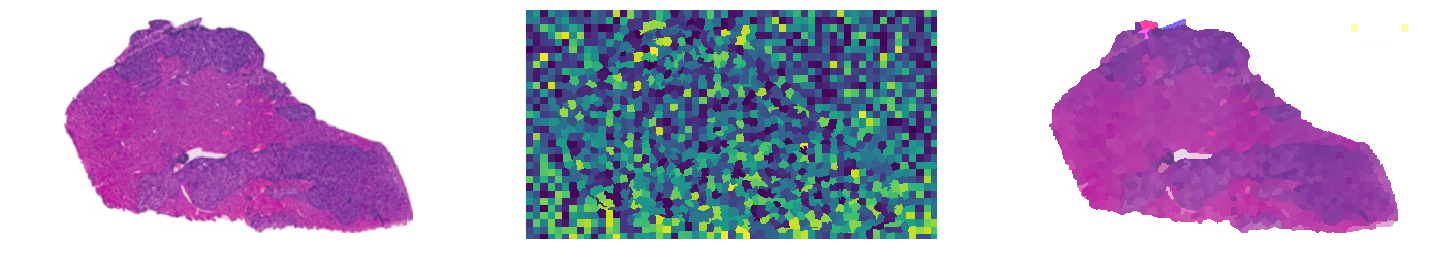

In [23]:
fig, axes = plt.subplots(1,3,figsize=(25,5))

axes[0].imshow(array_input);
axes[0].axis('off');

axes[1].imshow(liverA_seg_rand);
axes[1].axis('off');

axes[2].imshow(liverA_seg_color);
axes[2].axis('off');

Export to a png for manipulation in Fiji/ImageJ.

In [26]:
imageio.imwrite('/myvol/data2/pics/liver_seg.png', liverA_seg_color)

Read in the adjusted image.

In [27]:
liverI = Image.open('/myvol/data2/pics/liver_seg_rb_black.tif').convert('RGB')
liverA = np.array(liverI)

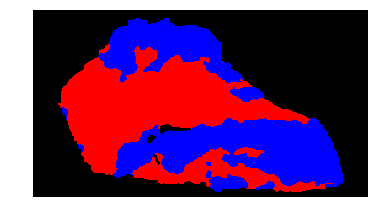

In [28]:
plt.imshow(liverA);
plt.axis('off');

In [29]:
liverA_lowres = make_low_res(liverA, background=0)

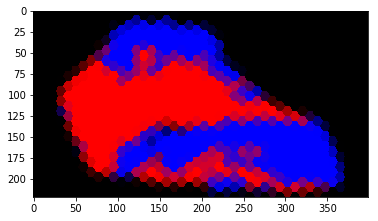

In [30]:
liverA_lowres[75,105]
plt.imshow(liverA_lowres);
# plt.axis('off');

# Other Methods of Segmentation

Here's if I want to explore more automated ways of doing this. 

### KMeans

In [726]:
flattened_liverA = liver_origA.reshape(-1,liver_origA.shape[-1])
kmeans = KMeans(n_clusters=3).fit(flattened_liverA)
labels = kmeans.labels_.reshape(liver_origA.shape[:2])

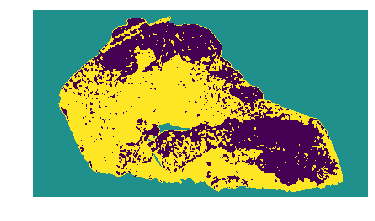

In [727]:
plt.imshow(labels)
plt.axis('off');

In [728]:
labels = (labels*(255/3)).astype(np.uint8)

In [731]:
labels

array([[85, 85, 85, ..., 85, 85, 85],
       [85, 85, 85, ..., 85, 85, 85],
       [85, 85, 85, ..., 85, 85, 85],
       ...,
       [85, 85, 85, ..., 85, 85, 85],
       [85, 85, 85, ..., 85, 85, 85],
       [85, 85, 85, ..., 85, 85, 85]], dtype=uint8)

In [732]:
clustered_labels = make_low_res(labels, background=(255/3))

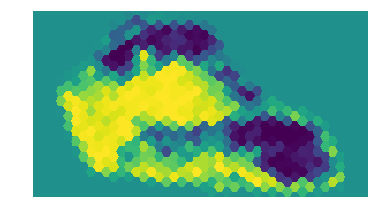

In [736]:
plt.imshow(clustered_labels)
plt.axis('off');

In [205]:
clustered_lowres

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255,   1, ..., 255, 255, 255],
       [255, 255,   1, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ...,   1, 255, 255],
       [255, 255, 255, ...,   1, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]])